# Chunking tutorial, fastest using xxlarge jupyter notebook on are.nci.org.au, possible on small

Time series of circumpolarly integrated surface speed under MW perturbations

In [1]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np

import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import glob
import os

In [2]:
session=cc.database.create_session()
expt = '01deg_jra55v13_ryf9091'

In [32]:
from dask.distributed import Client
import dask

c=Client(local_directory = '/g/data/v45/qo9901/') 
c 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39985/status,
Dashboard: /proxy/39985/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40445,Workers: 7
Dashboard: /proxy/39985/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:42191,Total threads: 4
Dashboard: /proxy/35133/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:41373,


2024-08-19 14:56:30,339 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:34703' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('sum-31ac1b41ea5f1e6a3ec8d2f7c4311a2f', 39, 0, 3), ('rechunk-split-rechunk-merge-49d5bda949ad0759063af0deaf61d63c', 36, 1, 2), ('rechunk-merge-49d5bda949ad0759063af0deaf61d63c', 36, 1, 3), ('sum-aggregate-9207a4d09b3f15fe55dcae90cc92347a', 6), ('rechunk-merge-49d5bda949ad0759063af0deaf61d63c', 39, 0, 1), ('sum-31ac1b41ea5f1e6a3ec8d2f7c4311a2f', 39, 1, 1), ('sum-aggregate-9207a4d09b3f15fe55dcae90cc92347a', 38), ('sum-aggregate-9207a4d09b3f15fe55dcae90cc92347a', 28), ('getitem-f69876840cf5f0681368297a756dec9f', 39, 0, 1, 2), ('getitem-a1d4b059e24050c68198e8eacde94155', 39, 0, 1, 2), ('sum-31ac1b41ea5f1e6a3ec8d2f7c4311a2f', 39, 1, 0), ('rechunk-merge-49d5bda949ad0759063af0deaf61d63c', 12, 0, 1), ('rechunk-merge-49d5bda949ad0759063af0deaf61d63c', 39, 0, 0), ('sum-partial-f425a906532a03bbb1c1c59929a8a16

In [4]:
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'

lat_lim = slice(-79, -60)
lon_lim = slice(-279.99,80)

In [5]:
ht = cc.querying.getvar(exp_wthmp, 'ht', session, n=1).drop(['geolat_t', 'geolon_t']).sel(yt_ocean=lat_lim).load() #.drop(['geolat_c', 'geolon_c'])
hu = cc.querying.getvar(exp_wthmp, 'hu', session, n=1).drop(['geolat_c', 'geolon_c']).sel(yu_ocean=lat_lim).load() #.drop(['geolat_c', 'geolon_c'])

In [18]:
u_wthmp = cc.querying.getvar(expt=exp_wthmp, variable='u', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='2110-01-31 00:00:00', 
                          end_time='2159-12-31 00:00:00').sel(yu_ocean = lat_lim).isel(st_ocean = 0)
v_wthmp = cc.querying.getvar(expt=exp_wthmp, variable='v', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='2110-01-31 00:00:00', 
                          end_time='2159-12-31 00:00:00').sel(yu_ocean = lat_lim).isel(st_ocean = 0)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

In [8]:
#get access grid to integrate

In [13]:
# NEEDload coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [14]:
# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

In [15]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [16]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

In [19]:
vel = xr.merge([coordinates, u_wthmp, v_wthmp, ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [20]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=False)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [21]:
grid = xgcm.Grid(vel, periodic=False, metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center

In [22]:
# creating mask to highlight slope and shelf processes, looking only at regions shallower than 2000m
cluster_mask_access = xr.where(hu < 1000, True, False)

In [23]:
area_u = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_u', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(xu_ocean= lon_lim, yu_ocean = lat_lim)
circ_ASC_area = (area_u*cluster_mask_access).sum()                                                                                                                                                                                        

Now we want to calculate a time series for circumpolarly averaged surface speed. With the masking and without any chunking we do so as follows

In [18]:
speed_wthmp = np.sqrt(u_wthmp**2 + v_wthmp**2).where(cluster_mask_access == True)
speed_wthmp_timeseries = grid.integrate(speed_wthmp, ['X','Y'])

However, when the intermediate step before printing is looked at, the chunks are very small (<1MB) and there are many tasks, which will result in longer compute time. If you run ```speed_wthmp_timeseries.load()``` it will likely crash

In [19]:
speed_wthmp

<xarray.DataArray (time: 600, yu_ocean: 440, xu_ocean: 3600)> Size: 4GB
dask.array<where, shape=(600, 440, 3600), dtype=float32, chunksize=(1, 250, 400), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02

Now let's try to rechunk u_wthmp and v_wthmp, 100MB to <1GB is a good rule of thumb. 

In [20]:
u_wthmp_chunk = u_wthmp.chunk({'time':100,'xu_ocean':1200,'yu_ocean': 250})
v_wthmp_chunk = v_wthmp.chunk({'time':100,'xu_ocean':1200,'yu_ocean': 250})
v_wthmp_chunk

<xarray.DataArray 'v' (time: 600, yu_ocean: 440, xu_ocean: 3600)> Size: 4GB
dask.array<rechunk-merge, shape=(600, 440, 3600), dtype=float32, chunksize=(100, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
Attributes:
    long_name:      j-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_y_velocity
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...

In [21]:
speed_wthmp_chunk = np.sqrt(u_wthmp_chunk**2 + v_wthmp_chunk**2).where(cluster_mask_access == True)
speed_wthmp_chunk_timeseries = grid.integrate(speed_wthmp_chunk, ['X','Y'])
speed_wthmp_chunk # many fewer graph layers this time

<xarray.DataArray (time: 600, yu_ocean: 440, xu_ocean: 3600)> Size: 4GB
dask.array<where, shape=(600, 440, 3600), dtype=float32, chunksize=(100, 250, 1200), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02

Crucially, if the chunking is not computed on dask before being used in your calculation, when `u_wthmp_chunk` is called, the rechunking is computed each time, resulting in a slower calculation. Running ```speed_wthmp_chunk_timeseries.load()``` will likely fail too. We can check a subset of data to see this happening.

In [24]:
%%time
## choosing only 10 years of CHUNKED data
n = 1
speed_wthmp = np.sqrt(u_wthmp_chunk.isel(time = slice(120*n, 120*(n+1)))**2 + v_wthmp_chunk.isel(time = slice(120*n, 120*(n+1)))**2).where(cluster_mask_access == True)
speed_wthmp_chunk_t = (grid.integrate(speed_wthmp, ['X','Y']).load()/circ_ASC_area)


CPU times: user 19.5 s, sys: 1.27 s, total: 20.8 s
Wall time: 2min 11s


In [26]:
%%time
## choosing only 10 years of unchunked data, wall time is slower than that of chunked data!

speed_wthmp = np.sqrt(u_wthmp.isel(time = slice(120*n, 120*(n+1)))**2 + v_wthmp.isel(time = slice(120*n, 120*(n+1)))**2).where(cluster_mask_access == True)
speed_wthmp_coast_t = grid.integrate(speed_wthmp, ['X','Y']).load()/circ_ASC_area

CPU times: user 28 s, sys: 1.07 s, total: 29 s
Wall time: 1min 16s


Therefore, we load the chunked data. On the intake catalog, if the chunking kwargs are added in the beginning, the data should already be loaded and this step would not be neccessary. 

In [41]:
%%time
u_wthmp_chunk.load(), v_wthmp_chunk.load()

(<xarray.DataArray 'u' (time: 600, yu_ocean: 440, xu_ocean: 3600)> Size: 4GB
 array([[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [ 0.03613812,  0.03168876,  0.02869883, ...,  0.048242  ,
           0.04387836,  0.04004395],
         [ 0.03526715,  0.03102086,  0.02941158, ...,  0.04694905,
           0.0435827 ,  0.03973115],
         [ 0.03503266,  0.03239677,  0.03183516, ...,  0.04314907,
           0.04152586,  0.03884263]],
 
        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
       

In [28]:
%%time
## this is now a lot faster to load for 10 years of data
speed_wthmp = np.sqrt(u_wthmp_chunk.isel(time = slice(120*n, 120*(n+1)))**2 + v_wthmp_chunk.isel(time = slice(120*n, 120*(n+1)))**2).where(cluster_mask_access == True)
speed_wthmp_chunk_t= grid.integrate(speed_wthmp, ['X','Y']).load()/circ_ASC_area


CPU times: user 26.2 s, sys: 1.47 s, total: 27.7 s
Wall time: 1min 49s


In [29]:
speed_wthmp_chunk = np.sqrt(u_wthmp_chunk**2 + v_wthmp_chunk**2).where(cluster_mask_access == True)
speed_wthmp_chunk_timeseries = grid.integrate(speed_wthmp_chunk, ['X','Y'])

In [30]:
%%time
## now it is possible to compute the whole timeseries in one go. 
speed_wthmp_chunk_timeseries.load()

2024-08-16 12:06:08,630 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.73 GiB -- Worker memory limit: 4.50 GiB
2024-08-16 12:06:50,048 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.01 GiB -- Worker memory limit: 4.50 GiB
2024-08-16 12:06:54,105 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.63 GiB -- Worker memory limit: 4.50 GiB
2024-08-16 12:06:54,117 - distributed.worker.memory - WARNING - Worker is at 79% memory usage. Resuming worker. Process memo

CPU times: user 1min 32s, sys: 5.68 s, total: 1min 37s
Wall time: 7min 16s


<xarray.DataArray (time: 600)> Size: 2kB
array([2.4590647e+11, 3.4526809e+11, 3.6069864e+11, 3.7339057e+11,
       3.4208281e+11, 2.5507666e+11, 2.7241053e+11, 2.2662226e+11,
       1.7503368e+11, 1.7190771e+11, 1.9223613e+11, 2.1878024e+11,
       2.4658004e+11, 3.4547696e+11, 3.6246186e+11, 3.7434029e+11,
       3.4252813e+11, 2.5478544e+11, 2.7292264e+11, 2.2635758e+11,
       1.7531640e+11, 1.7323157e+11, 1.9426850e+11, 2.2103355e+11,
       2.4894318e+11, 3.4805855e+11, 3.6583109e+11, 3.7591699e+11,
       3.4597929e+11, 2.5808067e+11, 2.7552950e+11, 2.2898216e+11,
       1.7697181e+11, 1.7465503e+11, 1.9583825e+11, 2.2299987e+11,
       2.5058468e+11, 3.5019309e+11, 3.6764988e+11, 3.7618726e+11,
       3.4602362e+11, 2.5863073e+11, 2.7605005e+11, 2.3038385e+11,
       1.7732654e+11, 1.7459085e+11, 1.9585548e+11, 2.2352088e+11,
       2.5236023e+11, 3.5239405e+11, 3.7054546e+11, 3.8052590e+11,
       3.5010311e+11, 2.6160765e+11, 2.7767993e+11, 2.3220955e+11,
       1.7885841e+11, 1.7672466e+11, 1.9789326e+11, 2.2567400e+11,
       2.5389724e+11, 3.5458961e+11, 3.7131341e+11, 3.8059655e+11,
       3.5071594e+11, 2.6164414e+11, 2.7979579e+11, 2.3330338e+11,
       1.7950356e+11, 1.7790286e+11, 1.9982968e+11, 2.2663987e+11,
       2.5440536e+11, 3.5537374e+11, 3.7323558e+11, 3.8191710e+11,
       3.5430089e+11, 2.6464141e+11, 2.8194501e+11, 2.3593704e+11,
...
       2.4812614e+11, 2.4611062e+11, 2.8404390e+11, 3.0847048e+11,
       3.3876620e+11, 4.3265062e+11, 4.4894149e+11, 4.6023718e+11,
       4.4570601e+11, 3.4793675e+11, 3.6391040e+11, 3.1227789e+11,
       2.4806272e+11, 2.4649225e+11, 2.8407067e+11, 3.0705982e+11,
       3.3639052e+11, 4.3679665e+11, 4.5356791e+11, 4.6505076e+11,
       4.4870871e+11, 3.4879694e+11, 3.6524563e+11, 3.1535802e+11,
       2.5052463e+11, 2.4812906e+11, 2.8722722e+11, 3.1118600e+11,
       3.3909676e+11, 4.3422102e+11, 4.5447879e+11, 4.6604016e+11,
       4.4958564e+11, 3.5155775e+11, 3.6702270e+11, 3.1681996e+11,
       2.5219793e+11, 2.4902176e+11, 2.8898460e+11, 3.1184005e+11,
       3.4051467e+11, 4.3547578e+11, 4.5276375e+11, 4.6904502e+11,
       4.4948816e+11, 3.5298293e+11, 3.6938872e+11, 3.1821644e+11,
       2.5415121e+11, 2.5106088e+11, 2.9101140e+11, 3.1401961e+11,
       3.4220396e+11, 4.4045913e+11, 4.5867195e+11, 4.6804592e+11,
       4.5246903e+11, 3.5604277e+11, 3.7309855e+11, 3.2297914e+11,
       2.5596900e+11, 2.5400430e+11, 2.9372888e+11, 3.1619953e+11,
       3.4393358e+11, 4.3947626e+11, 4.5732620e+11, 4.7106956e+11,
       4.5372437e+11, 3.5890613e+11, 3.7621789e+11, 3.2650491e+11,
       2.5932895e+11, 2.5723879e+11, 2.9957335e+11, 3.2091347e+11],
      dtype=float32)
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


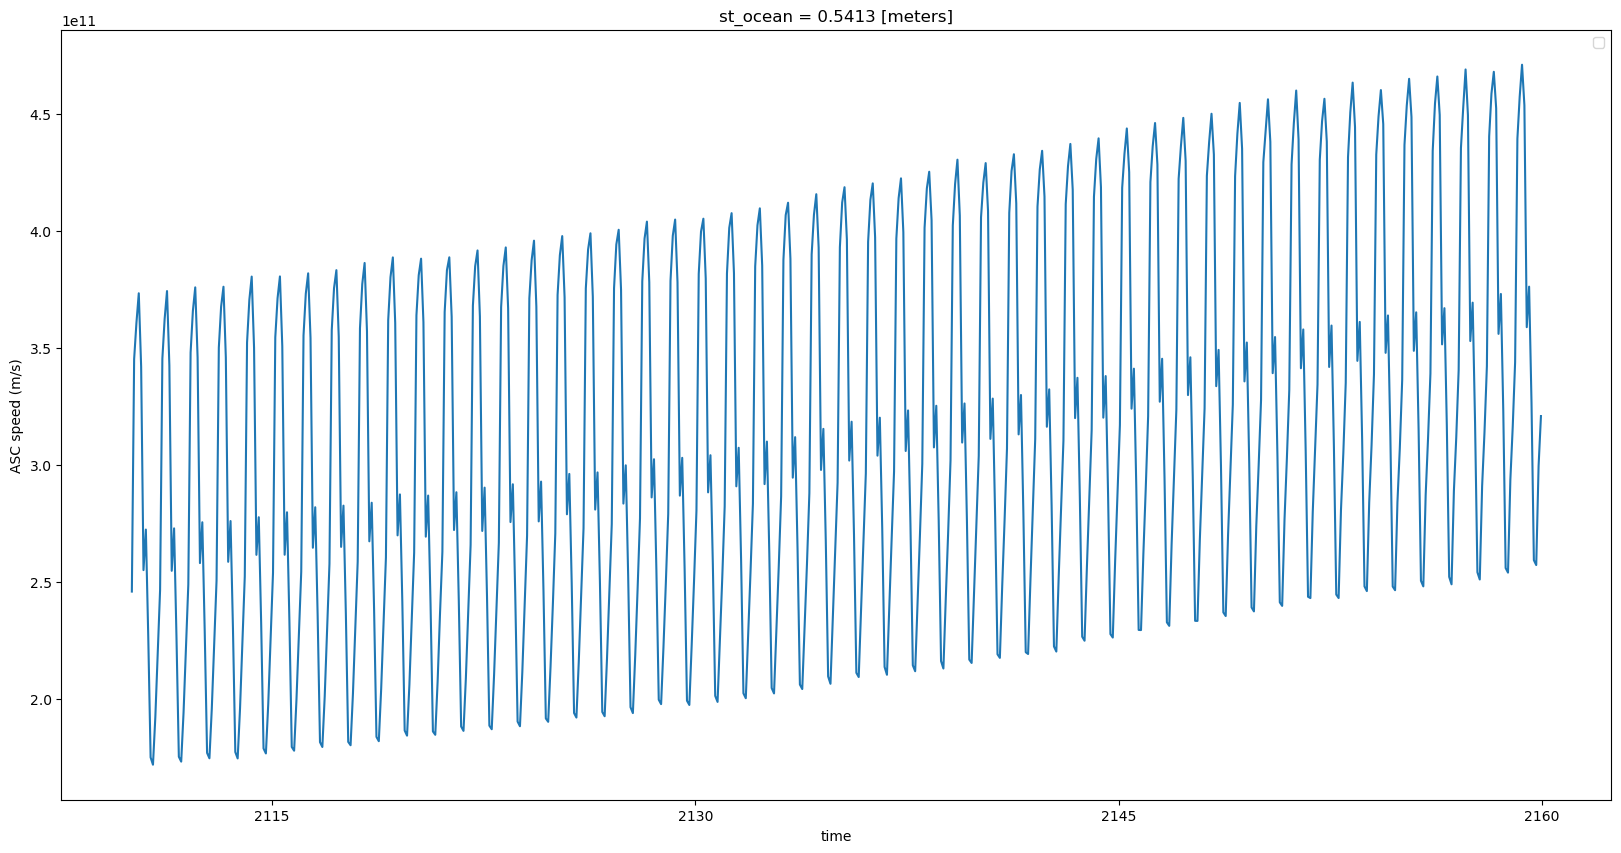

In [47]:
# Done!
plt.figure(figsize = (20,10))
speed_wthmp_chunk_timeseries.plot()
plt.ylabel('ASC speed (m/s)')
plt.legend()

In [ ]:
%%time
## if using larger chunks from the beginning
u_wthmp = cc.querying.getvar(expt=exp_wthmp, variable='u', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='2110-01-31 00:00:00', 
                          end_time='2159-12-31 00:00:00', chunks = {'time':100,'xu_ocean':1200,'yu_ocean': 250}).sel(yu_ocean = lat_lim).isel(st_ocean = 0)
v_wthmp = cc.querying.getvar(expt=exp_wthmp, variable='v', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='2110-01-31 00:00:00', 
                          end_time='2159-12-31 00:00:00', chunks = {'time':100,'xu_ocean':1200,'yu_ocean': 250}).sel(yu_ocean = lat_lim).isel(st_ocean = 0)


In [ ]:
%%time
speed_wthmp_chunkinit = np.sqrt(u_wthmp**2 + v_wthmp**2).where(cluster_mask_access == True)
speed_wthmp_chunkinit_timeseries = grid.integrate(speed_wthmp_chunkinit, ['X','Y']).load()


## Ignore for now - depth-av

In [ ]:
## what about for depth-av calculation? Here we add the chunking when the xarray file is being loaded, this is the most efficient way.

In [7]:
u_wthmp_z = cc.querying.getvar(expt=exp_wthmp, variable='u', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='2110-01-31 00:00:00', 
                          end_time='2159-12-31 00:00:00',chunks = {'time':100,'xu_ocean':1200,'yu_ocean': 250}).sel(yu_ocean = lat_lim)#.isel(st_ocean = 0)

v_wthmp_z = cc.querying.getvar(expt=exp_wthmp, variable='v', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='2110-01-31 00:00:00',
                               end_time='2159-12-31 00:00:00', chunks = {'time':100,'xu_ocean':1200,'yu_ocean': 250}).sel(yu_ocean = lat_lim)

## when printing we see that the chunking in time was not done, and therefore ideally we would rechunk again. 
## However, the dataarray is too large (250GB) to load to drive.                                
u_wthmp_z 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yu_ocean" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yu_ocean" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yu_ocean" starting at index 250. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3

<xarray.DataArray 'u' (time: 600, st_ocean: 75, yu_ocean: 440, xu_ocean: 3600)> Size: 285GB
dask.array<getitem, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 7, 240, 1200), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...

In [31]:
## trying again using better chunking in st_ocean
u_wthmp_z = cc.querying.getvar(expt=exp_wthmp, variable='u', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='2110-01-31 00:00:00', 
                          end_time='2159-12-31 00:00:00',chunks = {'time':100,'st_ocean':80,'xu_ocean':1200,'yu_ocean': 250}).sel(yu_ocean = lat_lim)#.isel(st_ocean = 0)

v_wthmp_z = cc.querying.getvar(expt=exp_wthmp, variable='v', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='2110-01-31 00:00:00',
                               end_time='2159-12-31 00:00:00', chunks = {'time':100,'st_ocean':80,'xu_ocean':1200,'yu_ocean': 250}).sel(yu_ocean = lat_lim)
u_wthmp_z

Process Dask Worker process (from Nanny):
2024-08-19 14:44:48,042 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/process.py", line 202, in _run
    target(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/nanny.py", line 1019, in _run
    asyncio_run(run(), loop_factory=get_loop_factory())
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/compatibility.py", line 236, in asyncio_run
    return loo

<xarray.DataArray 'u' (time: 600, st_ocean: 75, yu_ocean: 440, xu_ocean: 3600)> Size: 285GB
dask.array<getitem, shape=(600, 75, 440, 3600), dtype=float32, chunksize=(3, 75, 240, 1200), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...

In [8]:
# Import edges of st_ocean and add lat/lon dimensions:  , start_time=start_time_mw, end_time=end_time_mw,
st_edges_ocean = cc.querying.getvar(exp_wthmp, 'st_edges_ocean', session, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': hu.yu_ocean, 'xu_ocean': hu.xu_ocean}, axis=[1, 2])


# Adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# Change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean': 'st_ocean'}))


In [33]:
def calc_depthav_speed(u_field,v_field):
    speed_depthav_t = []
    for n in range(1):
        speed = np.sqrt(u_field.isel(time = slice(200*n, 200*(n+1)))**2 + v_field.isel(time = slice(200*n, 200*(n+1)))**2).where(cluster_mask_access == True)
        speed_depthav = (speed*thickness).sum('st_ocean') / thickness.sum('st_ocean')
        speed_depthav_t.append(grid.integrate(speed_depthav, ['X','Y']).load()/circ_ASC_area)
        print(n ,' is done')
    return xr.merge(speed_depthav_t)

In [34]:
%%time
speed_depthav_wthmp_t = calc_depthav_speed(u_wthmp_z,v_wthmp_z)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
 

KeyboardInterrupt: 

In [ ]:
import intake

catalog = intake.cat.access_nri
esm_datastore = catalog[expt_wthmp]

In [ ]:
esm_datastore_filtered = esm_datastore.search(
    variable=['u'], frequency="1month", require_all_on="path"
)

ds = esm_datastore_filtered.to_dask()